# Polyp Segmentation: Data Exploration and Dataset Preperation

# Importing libraries

In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
import random
import json
import cv2
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import segmentation_models as sm
from tensorflow.keras.metrics import Precision, Recall, MeanIoU, Accuracy, Mean, MeanSquaredError
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam, Nadam, AdamW
import keras.losses
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras import regularizers

Segmentation Models: using `tf.keras` framework.


# Exploring the Dataset

In [2]:
# The path to the "Kvasir-SEG" directory and the "images" and "masks" subdirectories
data_dir = "./Kvasir-SEG"
images_dir = os.path.join(data_dir, "images")
masks_dir = os.path.join(data_dir, "masks")

# Get a list of filenames in the "images" and "masks" subdirectories
images_files = sorted(os.listdir(images_dir))
masks_files = sorted(os.listdir(masks_dir))

# Check the file format of each image file in the images folder
images_formats = set()
for file_name in os.listdir(images_dir):
    file_path = os.path.join(images_dir, file_name)
    if os.path.isfile(file_path):
        file_format = file_name.split(".")[-1]
        images_formats.add(file_format)

# Check the file format of each image file in the masks folder
masks_formats = set()
for file_name in os.listdir(masks_dir):
    file_path = os.path.join(masks_dir, file_name)
    if os.path.isfile(file_path):
        file_format = file_name.split(".")[-1]
        masks_formats.add(file_format)

# Print the number of images and masks, along with their file formats
print(f"There are {len(images_files)} colonoscopic images with {images_formats} format")
print(f"There are {len(masks_files)} segmentation masked images with {masks_formats} format")

There are 1000 colonoscopic images with {'jpg'} format
There are 1000 segmentation masked images with {'jpg'} format


checking out images

RGB image size: (528, 622, 3)
masked image size: (528, 622, 3)
RGB pixels: min -> 0, max -> 255
masked pixel: min -> 0, max -> 255


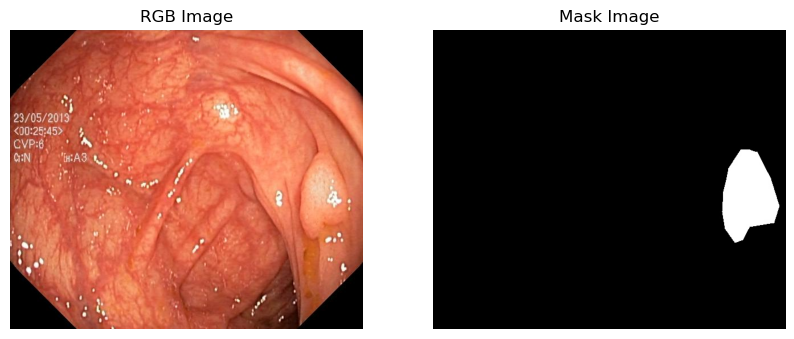

In [3]:
plt.figure(figsize=(10, 5))

# Read image (BGR by default)
x = random.randint(0, 999)
BGR_img1 = cv2.imread(os.path.join(images_dir,images_files[x]))
# Convert BGR to RGB
RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB)

# Read the image from mask images
mask_img1 = cv2.imread(os.path.join(masks_dir,masks_files[x]))

# Check shapes
print(f"RGB image size: {RGB_img1.shape}")
print(f"masked image size: {mask_img1.shape}")

# Check min-max pixels
print(f"RGB pixels: min -> {RGB_img1.min()}, max -> {RGB_img1.max()}")
print(f"masked pixel: min -> {mask_img1.min()}, max -> {mask_img1.max()}")

plt.subplot(1, 2, 1)  #(rows, columns, subplot number)
plt.imshow(RGB_img1)
plt.title('RGB Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_img1)
plt.title('Mask Image')
plt.axis('off')

# Show the figure with both images
plt.show()

since the masked image is grayscale we expect it to have 1 channel, here however they have 3 channels but visually it looks like a grayscale image. Now lets plot different aspects of all images to have a better view of the dataset.

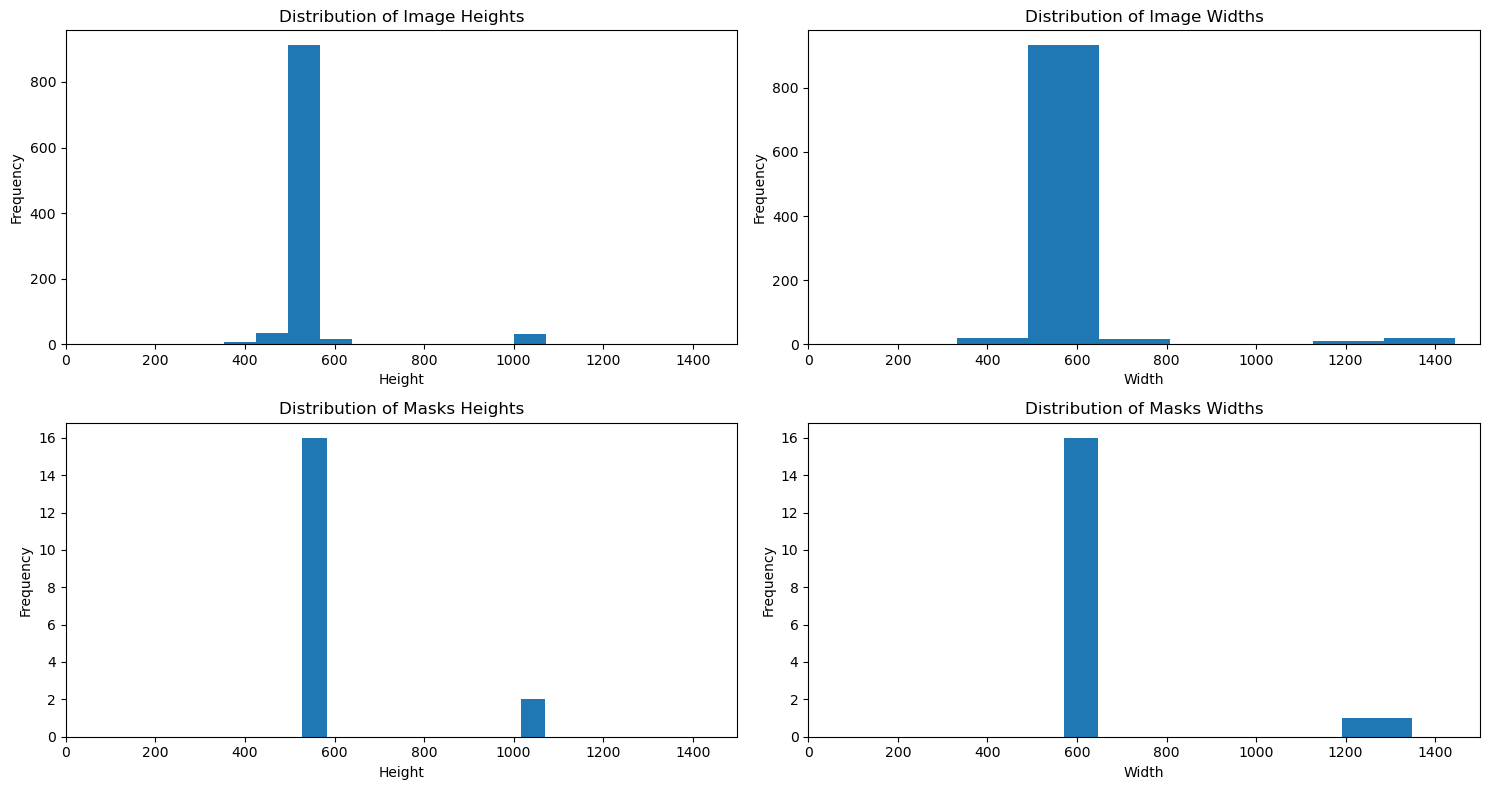

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

# height count image
heights_img = [cv2.imread(os.path.join(images_dir,images_files[i])).shape[0] for i in range(len(images_files))]
# height count masked
heights_msk = [cv2.imread(os.path.join(masks_dir,images_files[i])).shape[0] for i in range(len(masks_dir))]

# width count image
widths_img = [cv2.imread(os.path.join(images_dir,images_files[i])).shape[1] for i in range(len(images_files))]
# width count masked
widths_msk = [cv2.imread(os.path.join(masks_dir,images_files[i])).shape[1] for i in range(len(masks_dir))]

# Plot the histogram of heights, widths, colors (images)
axs[0][0].hist(heights_img)
axs[0][0].set_xlabel('Height')
axs[0][0].set_ylabel('Frequency')
axs[0][0].set_title('Distribution of Image Heights')

axs[0][1].hist(widths_img)
axs[0][1].set_xlabel('Width')
axs[0][1].set_ylabel('Frequency')
axs[0][1].set_title('Distribution of Image Widths')

# Plot the histogram of heights, widths, colors (masks)
axs[1][0].hist(heights_msk)
axs[1][0].set_xlabel('Height')
axs[1][0].set_ylabel('Frequency')
axs[1][0].set_title('Distribution of Masks Heights')

axs[1][1].hist(widths_msk)
axs[1][1].set_xlabel('Width')
axs[1][1].set_ylabel('Frequency')
axs[1][1].set_title('Distribution of Masks Widths')

axs[1][1].set_xlim([0, 1500])
axs[0][0].set_xlim([0, 1500])
axs[0][1].set_xlim([0, 1500])
axs[1][0].set_xlim([0, 1500])

plt.tight_layout()
plt.show()


In [5]:
file_path = os.path.join(data_dir, "kavsir_bboxes.json")
with open(file_path) as json_file:
    json_data = json.load(json_file)

rows_list = []
# Iterate through each item in the JSON dictionary
for key, value in json_data.items():
    height = value['height']
    width = value['width']

    # Check if "bbox" key exists and iterate through each bounding box
    for bbox in value.get('bbox', []):
        # Create a row with all desired information including bbox elements
        row = {
            'ID': key,
            'height': height,
            'width': width,
            'label': bbox['label'],
            'xmin': bbox['xmin'],
            'ymin': bbox['ymin'],
            'xmax': bbox['xmax'],
            'ymax': bbox['ymax']
        }
        rows_list.append(row)

# Convert the list of dicts into a DataFrame
df = pd.DataFrame(rows_list)
df.head()

ID  height  width  label  xmin  ymin  xmax  ymax
0  cju0qkwl35piu0993l0dewei2     529    622  polyp    38     5   430   338
1  cju0qoxqj9q6s0835b43399p4    1070   1348  polyp   194   284   913  1049
2  cju0qx73cjw570799j4n5cjze     529    619  polyp   187    14   543   526
3  cju0roawvklrq0799vmjorwfv     528    622  polyp   486    42   622   339
4  cju0roawvklrq0799vmjorwfv     528    622  polyp   329    71   437   150

In [6]:
print(f"Shape of the df: {df.shape}\n")
print(f"Value counts of column label: {df['label'].value_counts()}\n")
duplicates = df[df.duplicated('ID', keep=False)]
print(f"Number of rows with the same ID: {len(duplicates)}\n")
duplicates_count = duplicates.groupby('ID').size()
print(f"Rows with the same ID differentiated:\n{duplicates_count}\n")

columns_to_exclude = ['ID', 'label']
columns_to_include = df.columns.difference(columns_to_exclude)
print(f"Columns means:\n{df[columns_to_include].mean()}")


Shape of the df: (1071, 8)

Value counts of column label: label
polyp    1071
Name: count, dtype: int64

Number of rows with the same ID: 126

Rows with the same ID differentiated:
ID
cju0roawvklrq0799vmjorwfv     3
cju0sr5ghl0nd08789uzf1raf     2
cju15jr8jz8sb0855ukmkswkz     2
cju183od81ff608017ekzif89     2
cju1cu1u2474n0878tt7v4tdr     2
cju2hfqnmhisa0993gpleeldd     2
cju2hjrqcvi2j0801bx1i6gxg     2
cju2ma647l0nj0993ot4deq2q     2
cju2nqapmzvk20801f9us40dx     2
cju2rnkt22xep0801as160g9t     2
cju2rz4k434s70855wwx3ddtx     2
cju2ueb6j5ado0878vf5md13o     2
cju2uzabhs6er0993x3aaf87p     2
cju2y5zas8m7f0801d34g5owq     2
cju2zdhsczmn50988z64qwg2q     2
cju2zjcvj9qma0801dk71hhi0     2
cju2zo0fwzv580988qlijd2xa     2
cju30ajhw09sx0988qyahx9s8     2
cju31t8xd17bk0835rnb893jk     2
cju32a52lb9rc0799xi40qs00     3
cju32gzs6xo8x0993r8tedbpb     2
cju33belnbyhm0878yxl42233     2
cju34xspwzenf0993cyzajv9n     2
cju35k2fr3vc50988c85qkrwg     2
cju3uhb79gcgr0871orbrbi3x    10
cju3v56bwgy8v087

This explain why we have 1071 polyps when we have 1000 masks; some images has more than one polyp in them. these images names are shown above, lets view one of them for example:

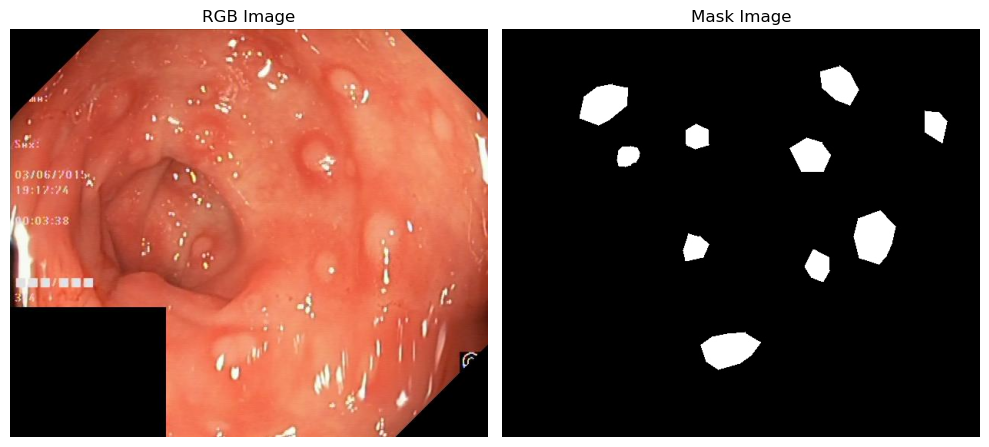

In [7]:
name = "cju3uhb79gcgr0871orbrbi3x.jpg"
image_path = os.path.join(images_dir, name)
mask_path = os.path.join(masks_dir, name)
image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('RGB Image')
axs[0].axis('off')

# Plot the mask image
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask Image')
axs[1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

With the mask bounding box coordinates we can see in which region are the polyps usually located. We devide the image to 16 equal squares, iterate over the bounding box data, calculate the center coordinates, and determine the grid cell for each bounding box based on the center coordinates.  The code section is compressed version of what below lines calculate:

```
df['x_center'] = (df['xmin'] + df['xmax']) / 2
df['y_center'] = (df['ymin'] + df['ymax']) / 2
df['grid_row'] = (df['y_center'] / (df['height'] / 4)).astype(int)
df['grid_col'] = (df['x_center'] / (df['width'] / 4)).astype(int)
df['grid_number'] = df['grid_row'] * 4 + df['grid_col'] + 1

```

In [8]:
df['grid_number'] = (((df['ymin'] + df['ymax']) / 2) / (df['height'] / 4)).astype(int) * 4 + (((df['xmin'] + df['xmax']) / 2) / (df['width'] / 4)).astype(int) + 1
df.head()

ID  height  width  label  xmin  ymin  xmax  ymax  \
0  cju0qkwl35piu0993l0dewei2     529    622  polyp    38     5   430   338   
1  cju0qoxqj9q6s0835b43399p4    1070   1348  polyp   194   284   913  1049   
2  cju0qx73cjw570799j4n5cjze     529    619  polyp   187    14   543   526   
3  cju0roawvklrq0799vmjorwfv     528    622  polyp   486    42   622   339   
4  cju0roawvklrq0799vmjorwfv     528    622  polyp   329    71   437   150   

   grid_number  
0            6  
1           10  
2           11  
3            8  
4            3

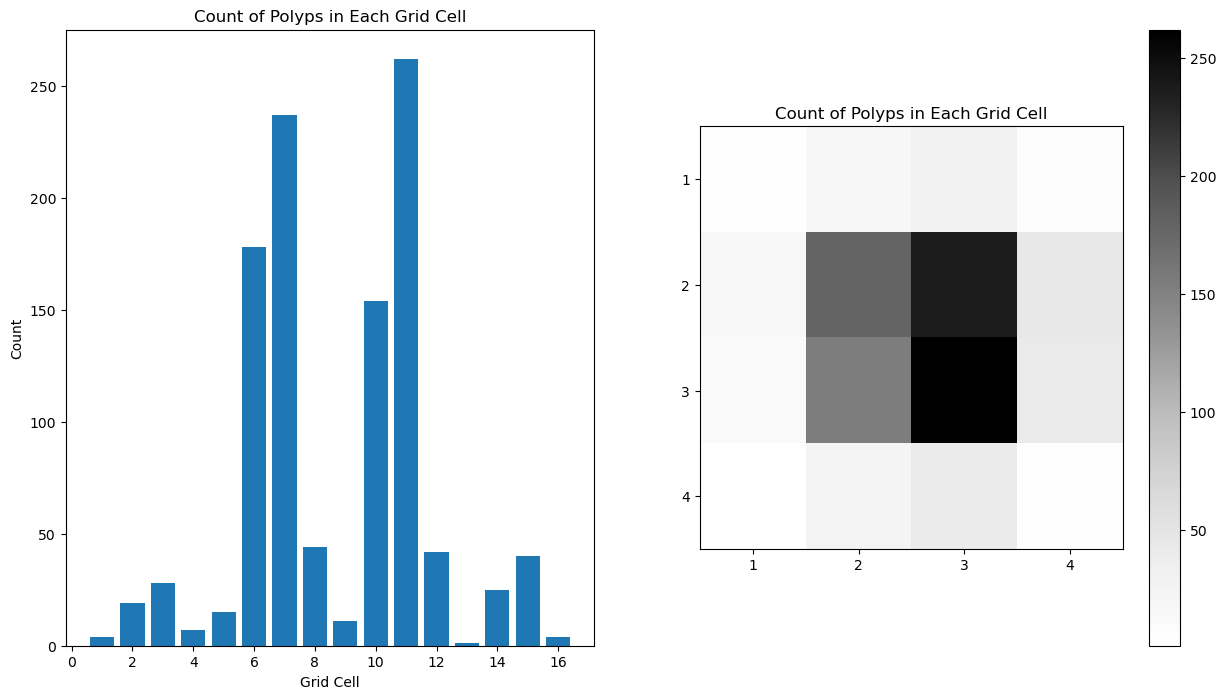

In [9]:
counts = df['grid_number'].value_counts().sort_index()
grid_counts = counts.values.reshape(4, 4)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
# Plotting
axs[0].bar(counts.index, counts.values)
axs[0].set_xlabel('Grid Cell')
axs[0].set_ylabel('Count')
axs[0].set_title('Count of Polyps in Each Grid Cell')

im = axs[1].imshow(grid_counts, cmap='Greys', interpolation='nearest')
fig.colorbar(im, ax=axs[1]) 
axs[1].set_xticks(np.arange(4))
axs[1].set_xticklabels(['1', '2', '3', '4'])
axs[1].set_yticks(np.arange(4))
axs[1].set_yticklabels(['1', '2', '3', '4'])
axs[1].set_title('Count of Polyps in Each Grid Cell')

plt.show()

We can see most polyps are located in the center of the image (Grid6 [2, 2], Grid7[2, 3], Grid10[3, 2], Grid11[3, 3]), therefore augmenting images with rotation and flip doesn't seem to help that much.

In [10]:
df['polyp_size'] = ((df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])) / (df['height'] * df['width']).astype(int)
df.head()

ID  height  width  label  xmin  ymin  xmax  ymax  \
0  cju0qkwl35piu0993l0dewei2     529    622  polyp    38     5   430   338   
1  cju0qoxqj9q6s0835b43399p4    1070   1348  polyp   194   284   913  1049   
2  cju0qx73cjw570799j4n5cjze     529    619  polyp   187    14   543   526   
3  cju0roawvklrq0799vmjorwfv     528    622  polyp   486    42   622   339   
4  cju0roawvklrq0799vmjorwfv     528    622  polyp   329    71   437   150   

   grid_number  polyp_size  
0            6    0.396720  
1           10    0.381344  
2           11    0.556639  
3            8    0.122990  
4            3    0.025979

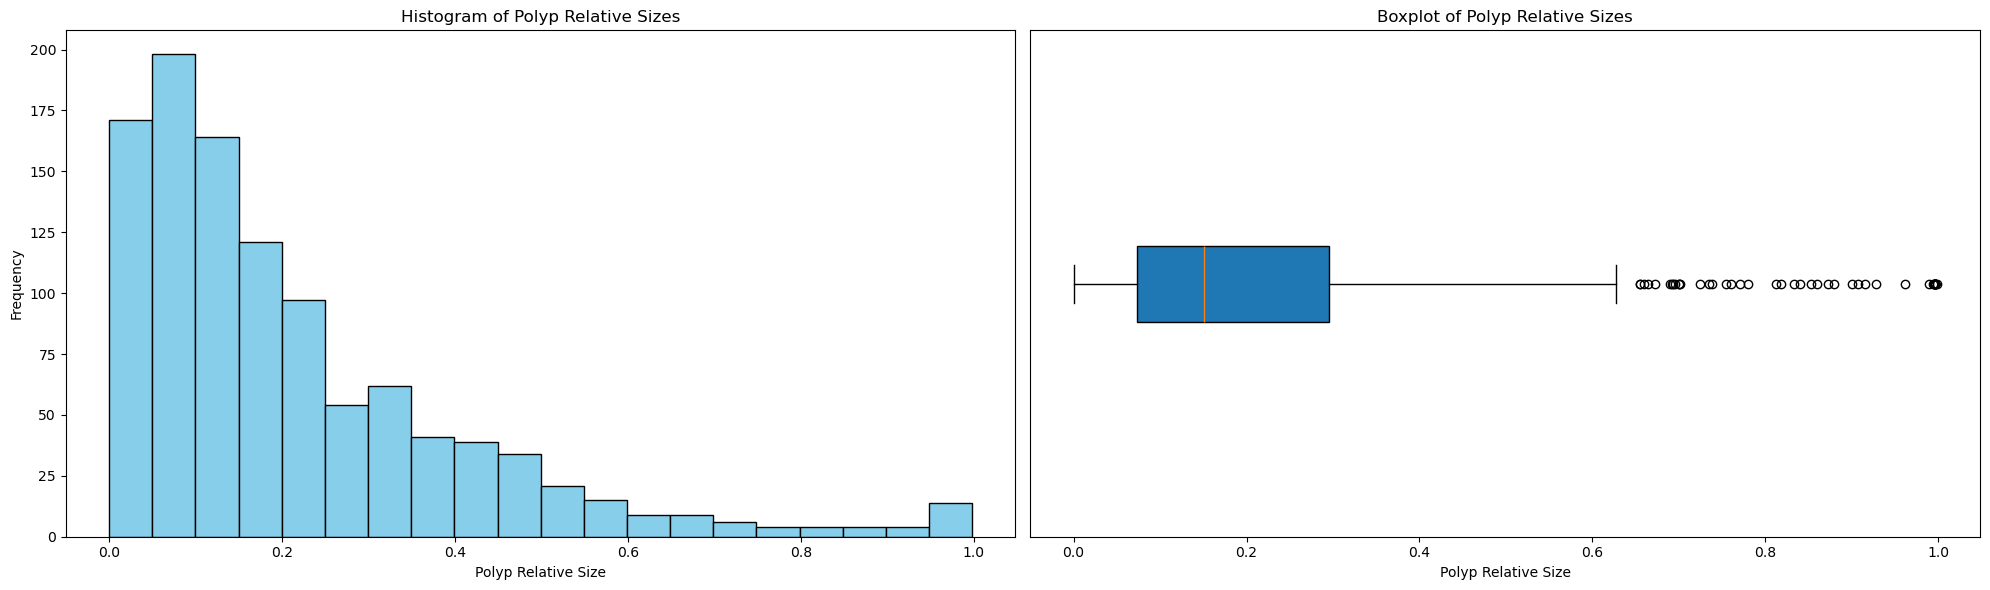

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# 1st subplot for the histogram
axs[0].hist(df['polyp_size'], bins=20, color='skyblue', edgecolor='black')
axs[0].set_title('Histogram of Polyp Relative Sizes')
axs[0].set_xlabel('Polyp Relative Size')
axs[0].set_ylabel('Frequency')

# 2nd subplot for the boxplot
axs[1].boxplot(df['polyp_size'], vert=False, patch_artist=True)  # 'vert=False' makes the boxplot horizontal
axs[1].set_title('Boxplot of Polyp Relative Sizes')
axs[1].set_xlabel('Polyp Relative Size')
axs[1].set_yticks([]) 

plt.tight_layout()
plt.show() 


The data reveal that the majority of polyp sizes fall within the 0.07 to 0.30 range, indicating that most polyps cover 7% to 30% of the total image area so very few images feature polyps occupying more than 50% of the image space. This detail is key to understanding why using just accuracy to judge our models might not work well. Since our polyp masks are just  masks are binary (black and white), making a ALL-black image will yield a high accurate, even if it’s not doing a good job of finding the polyps. This means we need a better way to see how well our models are really doing.


Now, let’s explore the color composition of the images. Understanding their color schemes is key for choosing image augmentation strategies. If the images share similar color palettes, altering the colors in the original images can help minimize model bias towards specific colors.

Describing colors using hue, saturation and brightness (also at times referred to as hue, saturation and lightness, or HSL) is a convenient way to organize differences in colors as perceived by humans. 

- **HUE** - Hue refers to the pure state of color. It is the natural color without mixing or modifying. In other words, Hue is the name by which we identify a color.

- **BRIGHTNESS (value)** - Value is the relative darkness or lightness of a color. This can be illustrated by the evidence of black and white photography of colored objects. The gradual adding of black color produces 'shades'. The gradual adding of white color produces 'Tints'. Maximum addition of white gives high tonal value. The middle colors between high and low is known as middle tones or half tone.

- **SATURATION (intensity)** - Chrome or saturation which indicates the purity of color is known as the intensity. Colors which are mixed and have ultimate degree of vividness are said to exhibit 'high intensity'. Two colors may have same hue value but yet differ in color strength.

In OpenCV, Hue has values from 0 to 180, and Saturation and Brighness both have 
values from 0 to 255. Thus, OpenCV uses HSV ranges between (0-180, 0-255, 0-255). In OpenCV, the H values 179, 178, 177 and so on are as close to the true RED as H value 1, 2, 3 and so on.

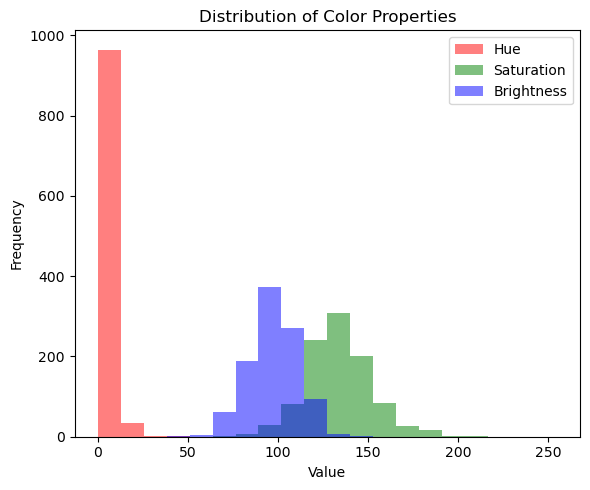

In [12]:
# Calculate the average brightness, hue, and saturation of the images
brightness_values = []
hue_values = []
saturation_values = []

for image_file in images_files:
    # Load the image
    image_path = os.path.join(images_dir, image_file)
    image = cv2.imread(image_path)

    # Convert the image to different color spaces
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate the average pixel intensities
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray)
    brightness_values.append(brightness)

    # Calculate the average hue value
    hue = np.mean(hsv_image[:, :, 0])
    hue_values.append(hue)

    # Calculate the average saturation value
    saturation = np.mean(hsv_image[:, :, 1])
    saturation_values.append(saturation)

x_axis_range = (0, 255)

# Display the histograms of hue, saturation, and brightness values
plt.figure(figsize=(6, 5))
n, bins, patches = plt.hist(hue_values, bins=20, range=x_axis_range, color='r', alpha=0.5, label='Hue')
plt.hist(saturation_values, bins=20, range=x_axis_range, color='g', alpha=0.5, label='Saturation')
plt.hist(brightness_values, bins=20, range=x_axis_range, color='b', alpha=0.5, label='Brightness')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Color Properties')
plt.legend()

plt.tight_layout() 
plt.show()

              Hue  Saturation  Brightness
count     1000.00     1000.00     1000.00
mean         9.03      134.14       97.48
std          2.40       18.28       13.46
min          4.28       75.41       48.13
25%          7.82      122.69       88.91
50%          8.65      133.69       97.60
75%          9.71      144.66      106.68
max         48.53      206.39      151.25
skewness     6.69        0.29       -0.23


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


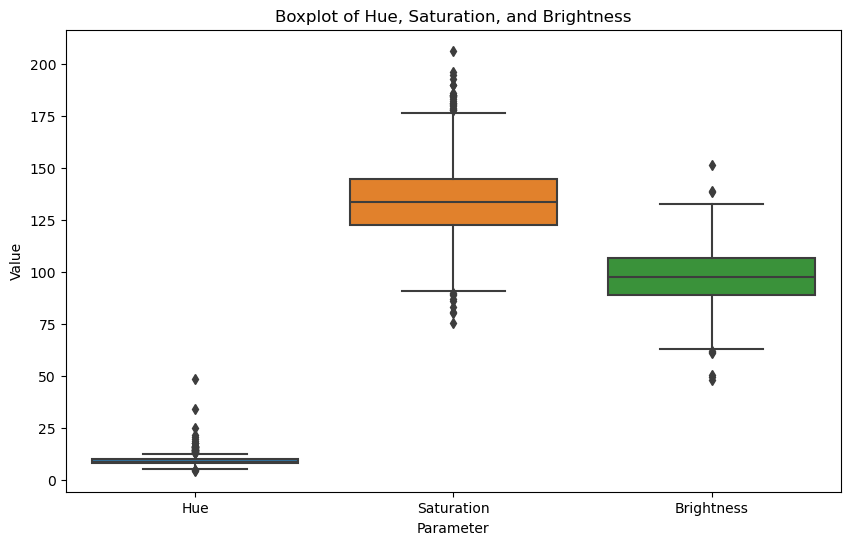

In [13]:
df = pd.DataFrame({'Hue': hue_values, 'Saturation': saturation_values, 'Brightness': brightness_values})

# Generate the summary statistics including skewness
summary = round(df.describe(), 2)
summary.loc['skewness'] = round(df.skew(), 2)
print(summary)

# Melting the DataFrame to make it long-form, which seaborn boxplot prefers
df_melted = df.melt(var_name='Parameter', value_name='Value')

plt.figure(figsize=(10, 6))  # Adjusts the size of the figure
sns.boxplot(x='Parameter', y='Value', data=df_melted)
plt.title('Boxplot of Hue, Saturation, and Brightness')
plt.ylabel('Value')
plt.xlabel('Parameter')
plt.show()


**Hue**<br>
The hue distribution covers a range of values from 4.28 to 48.53. The first quartile of 7.82 and the third quartile of 9.71 suggest that most hue values fall within this range, which corresponds to red color. The longer tail towards higher hue values  indicaties that there's predominant color or color bias in that direction.

**Saturation**<br>
The distribution of saturation is fairly symmetric and has wide range of values from 75.41 to 206.39.The mean saturation value is 134.14, indicating a moderate level of saturation on average.

**Brightness**<br>
Similar to saturation, The fairly symmetric distribution of brightness indicates a relatively balanced distribution of values across the range of 48.13 to 151.25. The symmetric shape suggests that there is no strong bias towards high or low brightness values. The mean brightness value is 97.48, indicating a moderate brightness level on average.

The color-box below displays the color generated from the mean HSV values:

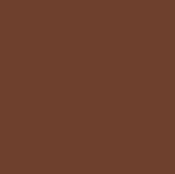

In [14]:
# Convert HSV to RGB
rgb_color = mcolors.hsv_to_rgb([df['Hue'].mean()/180, df['Saturation'].mean()/225, df['Brightness'].mean()/225])
fig, ax = plt.subplots(figsize=(2, 2))
fig.patch.set_facecolor(rgb_color)
ax.axis('off')
plt.show()

# Data Preprocessing

As observed earlier, the images vary in height and width, so resizing them for our custom model is advisable. However, pretrained models are designed to manage a variety of sizes effectively and do not require uniform image dimensions.
To prepare the image data for neural network layers that require floating-point inputs, we convert the pixel values to floating points by normalizing them. Since pixel values range from 0 to 255, dividing all pixel values by 255 will transform them into a range between 0 and 1, suitable for neural network processing.
We also verify whether any image files lack a corresponding mask file.

In [15]:
#Resizing images is optional but we do it :)
SIZE_X = 128
SIZE_Y = 128

image_files = sorted(os.listdir(images_dir))
mask_files = sorted(os.listdir(masks_dir))

# Check if image and mask filenames match
matching_files = [img for img in image_files if img in mask_files]
mismatched_files = [img for img in image_files if img not in mask_files]

print(f"Length of matched files: {len(matching_files)}")
print(f"Length of mismatched files: {len(mismatched_files)}")

Length of matched files: 1000
Length of mismatched files: 0


Before splitting the data into train and test sets, it’s noted that the grayscale mask images currently have 3 channels, similar to the colored RGB main images. We aim to resize our NumPy image array so that the mask images are converted to a single channel format, which is typical for grayscale images.

In [100]:
X = []
for img_name in image_files:
    img_path = os.path.join(images_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    # We set the image colors to BGR format for OpenCV convenience
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    X.append(img)
X = np.array(X)
X = X.astype('float32') / 255.0

Y = []
for mask_name in mask_files:
    mask_path = os.path.join(masks_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    # We set the masks to grayscale and add 1 channels
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
    mask = np.expand_dims(mask, axis=-1)
    Y.append(mask)
Y = np.array(Y)
Y = Y.astype('float32') / 255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"train size: {len(X_train)}, {len(Y_train)}, {X_train.shape}, {Y_train.shape}")
print(f"test size: {len(X_test)}, {len(Y_test)}, {X_test.shape}, {Y_test.shape}")

train size: 800, 800, (800, 128, 128, 3), (800, 128, 128, 1)
test size: 200, 200, (200, 128, 128, 3), (200, 128, 128, 1)


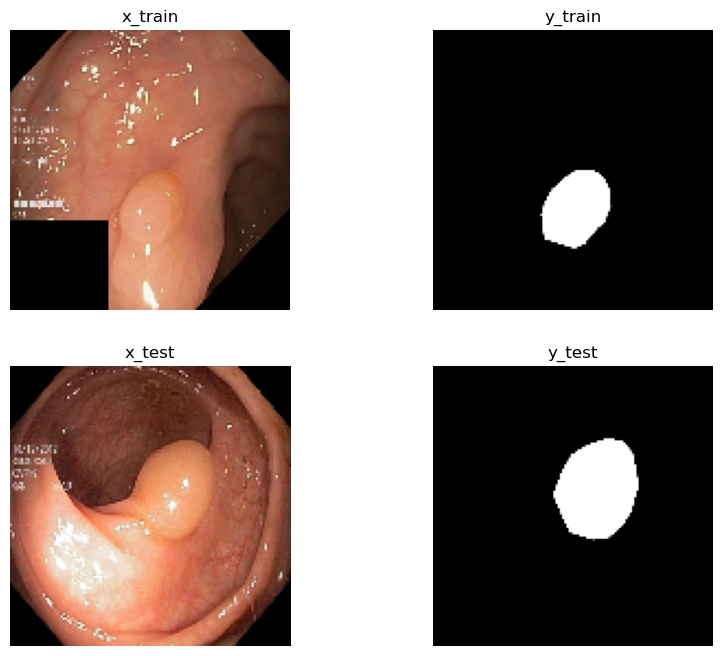

In [17]:
plt.figure(figsize=(10, 8))

# Read image (BGR by default)
x = random.randint(0, len(X_train))
y = random.randint(0, len(Y_test))

plt.subplot(2, 2, 1)  #(rows, columns, subplot number)
plt.imshow(X_train[x])
plt.title('x_train')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(Y_train[x], cmap='gray')
plt.title('y_train')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(X_test[y])
plt.title('x_test')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(Y_test[y], cmap='gray')
plt.title('y_test')
plt.axis('off')

# Show the figure with both images
plt.show()

# Custom U-Net model
U-Net is a type of convolutional neural network (CNN) designed for fast and precise segmentation of images. The architecture of U-Net is distinctive for its “U” shape, which is a design choice that facilitates the precise localization that image segmentation requires. It consists of two main parts:

- Contracting Path (Downsampling): The left side of the U shape, which captures the context in the image. This part consists of multiple convolutional layers and pooling layers, which reduce the spatial dimensions of the input image, effectively increasing the receptive field and enabling the model to understand more complex features.

- Expansive Path (Upsampling): The right side of the U shape, which enables precise localization. This section consists of upsampled feature maps concatenated with the correspondingly cropped feature maps from the contracting path, followed by convolutional layers. This design helps in precise localization by combining high-level semantic information (from the downsampling path) with low-level features (from the initial layers), making it easier to delineate boundaries of objects in the image.

One of the key features of U-Net is the use of skip connections, which directly concatenate feature maps from the downsampling path to the upsampling path. These connections help preserve spatial information lost during downsampling, which is critical for achieving high accuracy in segmentation tasks.

The below is the implementation of U-Net model

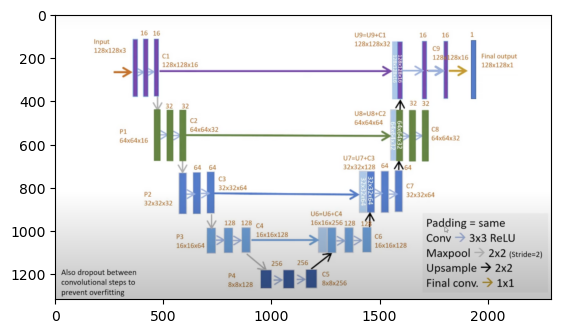

In [18]:
img = mpimg.imread('UNET.png')
plt.imshow(img)
plt.show()

#### Choosing a loss funtion: 

The `bce_jaccard_loss` is a combined loss function that integrates both Binary Cross-Entropy (BCE) loss and Jaccard loss (also known as the Intersection over Union or IoU loss) typically used in image segmentation tasks. This hybrid approach leverages the strengths of both loss functions to improve the model's segmentation accuracy by addressing their individual weaknesses.

- Binary Cross-Entropy (BCE) Loss
BCE loss is a commonly used loss function for binary classification problems, including binary image segmentation tasks where each pixel is classified as belonging to one of two classes (e.g., object or background). It calculates the distance between the predicted probability and the actual label (0 or 1) for each pixel.
-  Jaccard Loss (IoU Loss)
Jaccard loss is derived from the Jaccard index (IoU), a metric used to evaluate the similarity between the predicted segmentation and the ground truth. The IoU is the ratio of the intersection of the predicted and actual segmented areas to their union. Jaccard loss is defined as 1 minus the IoU to convert it into a loss function that can be minimized.

- `bce_jaccard_loss`
The `bce_jaccard_loss` function combines these two loss functions, taking advantage of BCE loss's ability to provide precise pixel-wise classification and Jaccard loss's robustness to the relative size of the objects in the image, making it more suitable for imbalance problems where the object of interest occupies a small portion of the image. This approach encourages the model to not only classify individual pixels accurately but also to match the overall shape and area of the target objects more closely, which can lead to improved segmentation performance.

- The Dice loss function
The Dice loss function (also known as the Sørensen-Dice coefficient) is based on the Dice coefficient, which is a measure of similarity over two sets. It is particularly popular in image segmentation tasks, especially in medical imaging, where it is crucial to accurately predict the shape and location of objects within images. The Dice loss function, a measure for comparing the similarity of two samples, is defined as 1 - *Dice coefficient* to frame it as a loss that can be minimized.



#### Choosing an optimizer:

- When working with segmentation tasks using a U-Net architecture and employing a combined loss function like bce_jaccard_loss (a mix of Binary Cross-Entropy and Jaccard index), choosing the right optimizer is crucial for the effectiveness and convergence speed of the model training. While there isn’t a one-size-fits-all optimizer, Adam optimizer is often recommended for a start due to its adaptiveness in learning rates for different parameters.



Normalization is definitely crucial for the process. Before i properly normalized, the IOU score and Dice score were less than zero, and the loss function wasn't working properly, so the model was not training correctly. After normalization and resizing, the problem was solved.

Before training, i tested different optimizers such as RMSprop, Adam, AdamW, and Adamax. I initially used the binary cross-entropy loss function, which didn't perform well. After some research, i found the reasons:

1. **Class Imbalance**: Medical images often show a significant class imbalance, where the region of interest is much smaller compared to the background. In our dataset, images mostly occupied 0.07 to 0.3 of the whole image. Binary cross-entropy (BCE) treats each pixel the same and does not differentiate between important and less important predictions, making it hard for the model to focus on the minority class, the region of interest.

2. **Spatial Context Ignored**: BCE loss calculates how accurate each pixel prediction is without considering how pixels relate to each other. This is a problem in medical images where knowing where pixels are in relation to each other is key for accurate segmentation. This loss doesn't directly help with making predictions that are smoothly connected and can penalize when predictions are broken up, which is often in medical image segmentation tasks.

3. **Dice Loss Compatibility**: Medical image segmentation often does better with measurements that look at how much the prediction and the actual overlap, like the Dice coefficient or IOU. These measurements directly address class imbalance by focusing on accurately outlining the region of interest. Unlike these, BCE doesn't directly promote this overlap, possibly leading to poorer segmentation performance.

4. **Threshold Sensitivity**: How a segmentation model that uses BCE loss performs can be very sensitive to the threshold chosen to decide the model's output. Choosing the best threshold becomes another challenge, especially when the model isn't specifically designed to improve overlap measurements like Dice or IOU.

So, in the end, i used the combination of BCE with Dice loss and IOU loss, and these were tested and used.The model is setting up two techniques—`EarlyStopping` and `ReduceLROnPlateau`—to improve the training of a neural network by monitoring its performance and adjusting the learning rate.

### EarlyStopping Parameters:

- **monitor='val_loss'**: This tells EarlyStopping to monitor the validation loss. The goal is to stop training when the validation loss stops improving.
- **patience=5**: This sets how many epochs to continue training after detecting that the validation loss has stopped improving. Here, it continues for 5 more epochs before stopping.
- **restore_best_weights=True**: After stopping, this will restore the model weights from the epoch with the best value of the monitored quantity, in this case, the lowest validation loss.

### ReduceLROnPlateau Parameters:

- **monitor='val_loss'**: Similar to EarlyStopping, this tells ReduceLROnPlateau to monitor the validation loss for any lack of improvement.
- **factor=0.1**: When a lack of improvement in the monitored quantity is detected, the learning rate is multiplied by this factor, here reducing it to 10% of its value.
- **patience=5**: This is the number of epochs with no improvement after which the learning rate will be reduced. It waits for 5 epochs before making any adjustment.
- **min_lr=1e-5**: This sets the lower bound on the learning rate. No matter how many times the learning rate is reduced, it won't go below this value, ensuring that the learning rate does not become too small.

Together, these techniques help in preventing overfitting (via early stopping) and in potentially escaping local minima or making fine adjustments to the model weights (by reducing the learning rate when progress stalls).


In [57]:
def my_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, x_train, y_train):
    #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)
    s = inputs

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s) # kernel_initializer: Initial weight assignment to start the training with. 
    c1 = tf.keras.layers.Dropout(0.1)(c1) #Dropout to avoid overfitting
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=sm.losses.bce_jaccard_loss, metrics=['accuracy', sm.metrics.f1_score, sm.metrics.iou_score])
    model.summary()
    
    model_checkpoint = ModelCheckpoint('./my_unet.keras', monitor='val_iou_loss', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8)

    results = model.fit(x_train, y_train, epochs = 100, validation_split = 0.2, batch_size = 32, callbacks=[model_checkpoint, early_stopping, reduce_lr],)

    return model, results


In [58]:
unet, unet_history = my_unet_model(SIZE_X, SIZE_Y, 3, X_train, Y_train)

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 128, 128,  │     448 │ input_layer_5[0][0]  │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_45          │ (None, 128, 128,  │       0 │ conv2d_95[0][0]      │
│ (Dropout)           │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 128, 128,  │   2,320 │ dropout_45[0][0]     │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_20    │ (None, 64, 64,    │       0 │ conv2d_96[0][0]      │
│ (MaxPooling2D)      │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 64, 64,    │   4,640 │ max_pooling2d_20[0]… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_46          │ (None, 64, 64,    │       0 │ conv2d_97[0][0]      │
│ (Dropout)           │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 64, 64,    │   9,248 │ dropout_46[0][0]     │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_21    │ (None, 32, 32,    │       0 │ conv2d_98[0][0]      │
│ (MaxPooling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 32, 32,    │  18,496 │ max_pooling2d_21[0]… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_47          │ (None, 32, 32,    │       0 │ conv2d_99[0][0]      │
│ (Dropout)           │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_100 (Conv2D) │ (None, 32, 32,    │  36,928 │ dropout_47[0][0]     │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_22    │ (None, 16, 16,    │       0 │ conv2d_100[0][0]     │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_101 (Conv2D) │ (None, 16, 16,    │  73,856 │ max_pooling2d_22[0]… │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_48          │ (None, 16, 16,    │       0 │ conv2d_101[0][0]     │
│ (Dropout)           │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_102 (Conv2D) │ (None, 16, 16,    │ 147,584 │ dropout_48[0][0]     │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_23    │ (None, 8, 8, 128) │       0 │ conv2d_102[0][0]   

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8100 - f1-score: 0.1689 - iou_score: 0.0932 - loss: 1.5047 - val_accuracy: 0.8329 - val_f1-score: 0.1994 - val_iou_score: 0.1110 - val_loss: 1.4573 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8491 - f1-score: 0.1779 - iou_score: 0.0980 - loss: 1.3807 - val_accuracy: 0.8329 - val_f1-score: 0.2723 - val_iou_score: 0.1581 - val_loss: 1.2721 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8494 - f1-score: 0.2639 - iou_score: 0.1525 - loss: 1.2325 - val_accuracy: 0.8353 - val_f1-score: 0.3068 - val_iou_score: 0.1817 - val_loss: 1.2269 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8325 - f1-score: 0.3142 - iou_score: 0.1866 - loss: 1.1992 - val_accuracy: 0.7648 - val_f1-score: 0.3300 - val_iou_score: 0.1983 - val_loss: 1.2340 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step -

### Visualization

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step


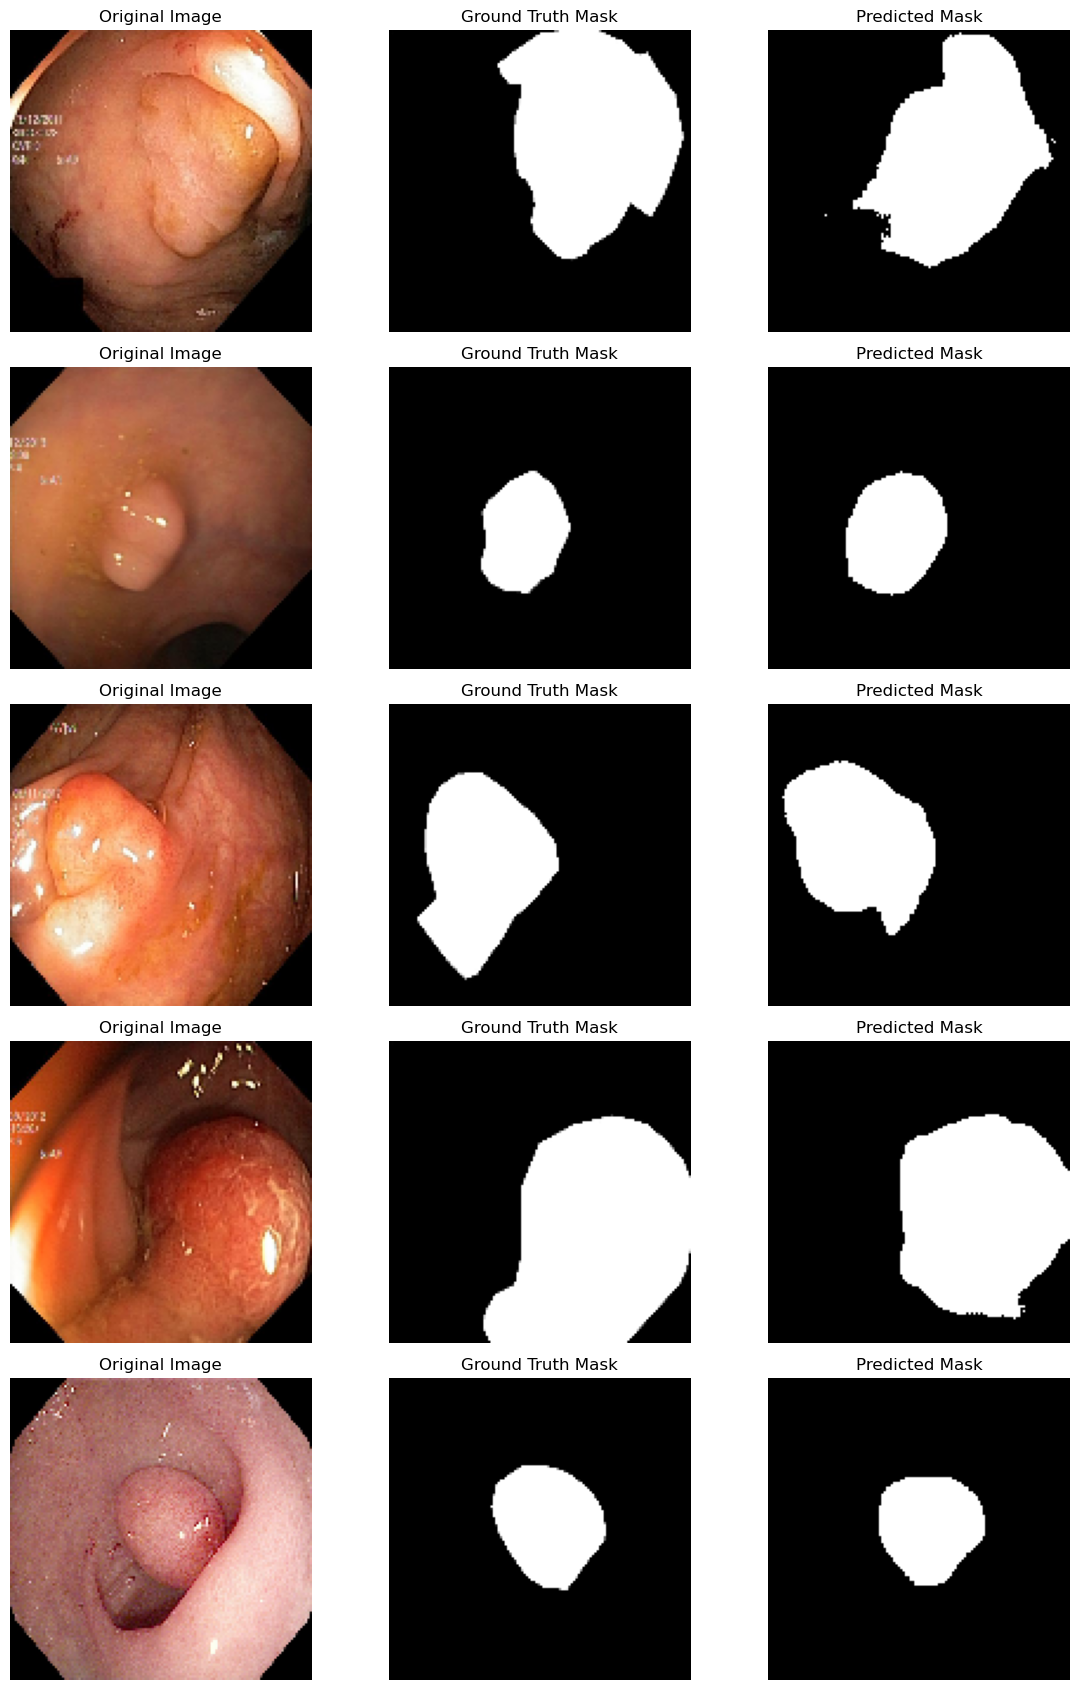

In [62]:
random_indices = random.sample(range(len(X_test)), 5)
preds_test = unet.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Initialize subplots
plt.figure(figsize=(12, 17))

for i, random_index in enumerate(random_indices):
    # Plot the image, ground truth mask, and predicted mask side by side
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(X_test[random_index]) 
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(Y_test[random_index], cmap='gray') 
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(preds_test_t[random_index], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Evaluation

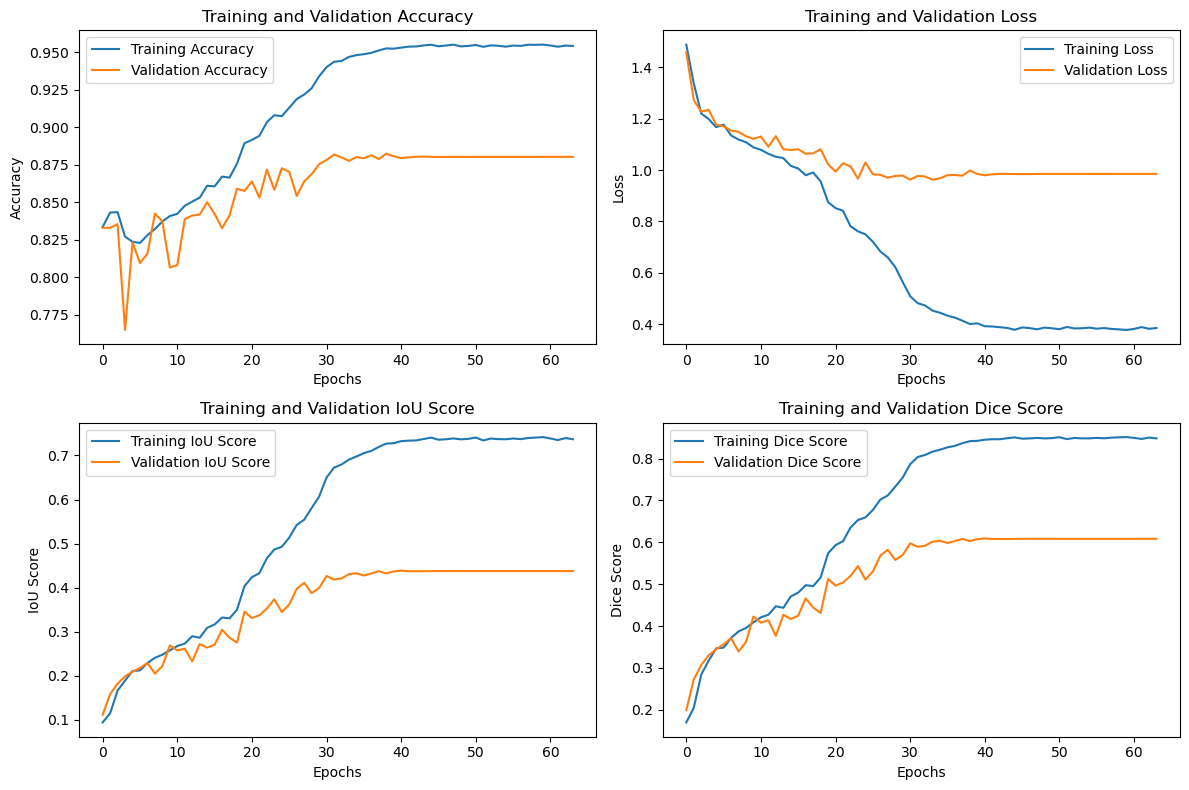

In [63]:
train_accuracy = unet_history.history['accuracy']
train_loss = unet_history.history['loss']
iou_score = unet_history.history['iou_score']
f1_score = unet_history.history['f1-score']

val_accuracy = unet_history.history['val_accuracy']
val_loss = unet_history.history['val_loss']
val_iou_score = unet_history.history['val_iou_score']
val_f1_score = unet_history.history['val_f1-score']

# Plot the learning curves
plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iou_score, label='Training IoU Score')
plt.plot(val_iou_score, label='Validation IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.title('Training and Validation IoU Score')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(f1_score, label='Training Dice Score')
plt.plot(val_f1_score, label='Validation Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()

plt.tight_layout()
plt.show()

## Results, Analysis and Report

multiple compinations were tested before reaching this result. Some of the results can be seen in the below images. All were obtained with epoch = 10 and batch_stize = 32:

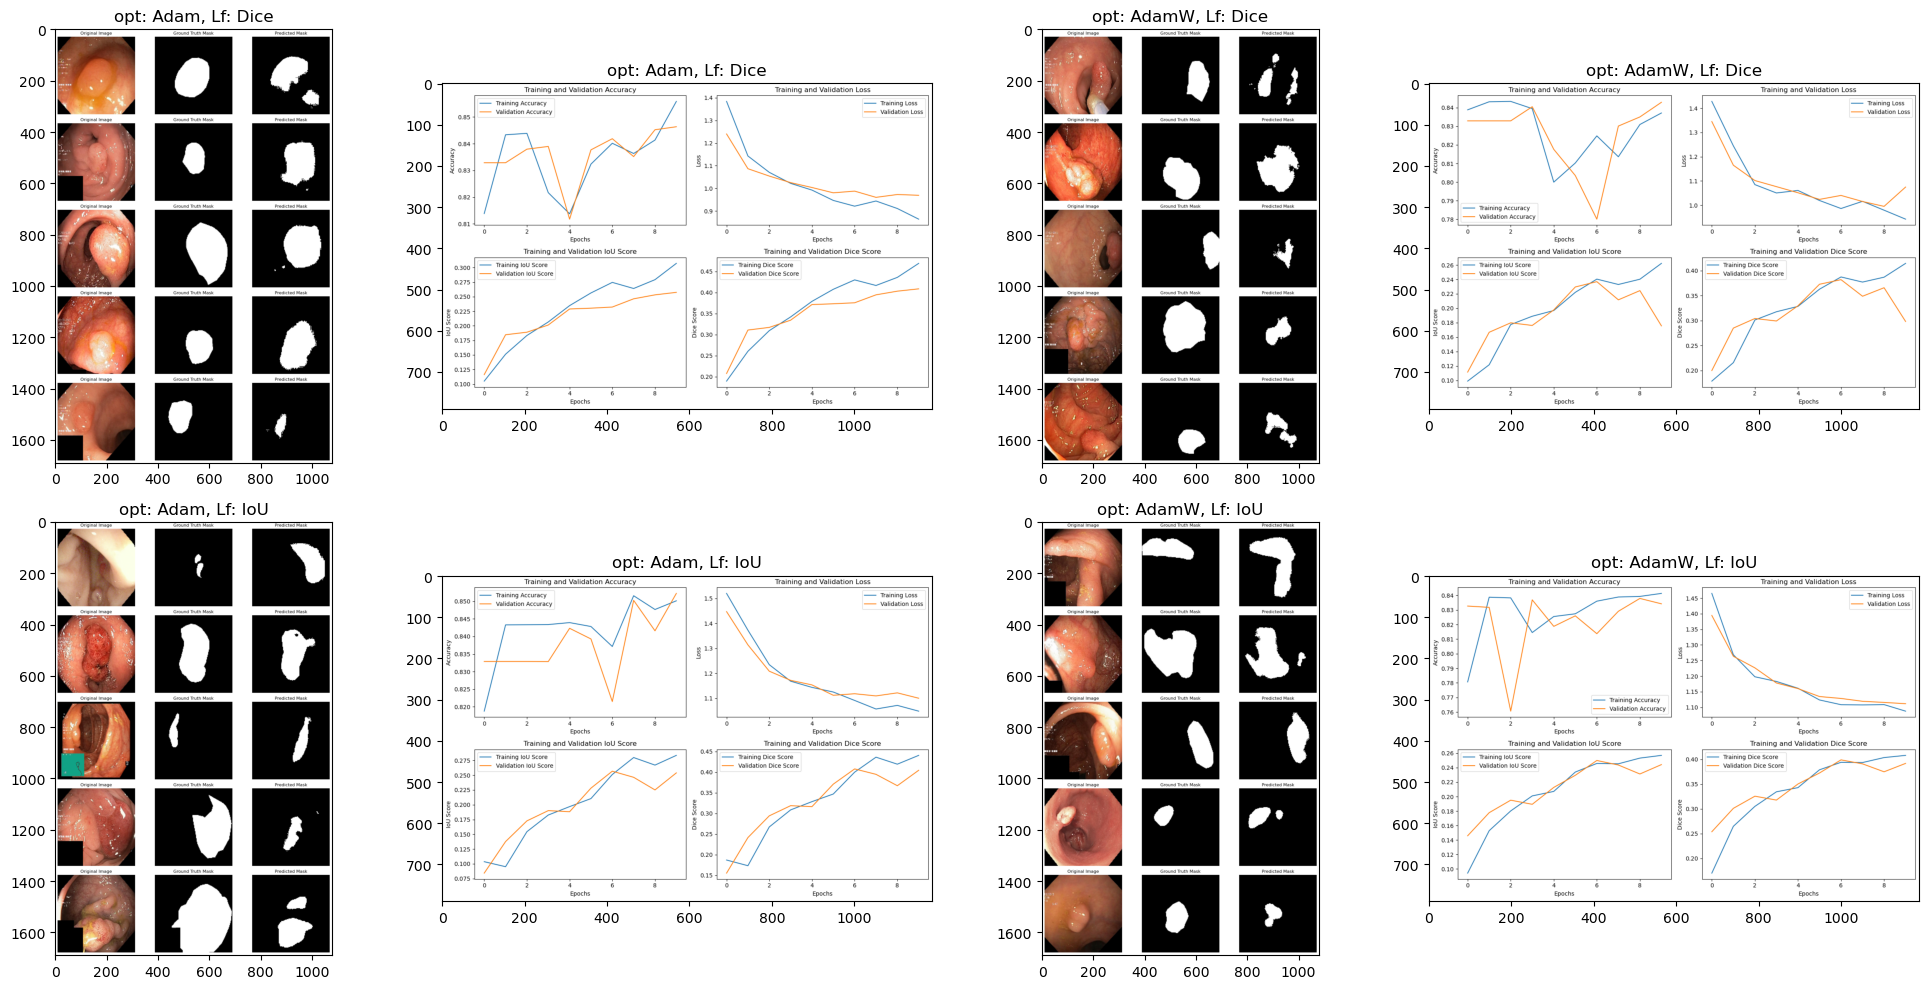

In [70]:
# Start figure
plt.figure(figsize=(20, 10))  # Adjusted for better visibility of 2 rows and 4 columns

# First row (Dices)
plt.subplot(2, 4, 1)
img = mpimg.imread('dice10e32b-adam.png')
plt.title('opt: Adam, Lf: Dice')
plt.imshow(img)

plt.subplot(2, 4, 2)
img = mpimg.imread('dice10e32b-adamplot.png')
plt.title('opt: Adam, Lf: Dice')
plt.imshow(img)

plt.subplot(2, 4, 3)
img = mpimg.imread('dice10e32b-adamw.png')
plt.title('opt: AdamW, Lf: Dice')
plt.imshow(img)

plt.subplot(2, 4, 4)
img = mpimg.imread('dice10e32b-adamwplot.png')
plt.title('opt: AdamW, Lf: Dice')
plt.imshow(img)

# Second row (IOUs)
plt.subplot(2, 4, 5)
img = mpimg.imread('iou10e32b-adam.png')
plt.title('opt: Adam, Lf: IoU')
plt.imshow(img)

plt.subplot(2, 4, 6)
img = mpimg.imread('iou10e32b-adamplot.png')
plt.title('opt: Adam, Lf: IoU')
plt.imshow(img)

plt.subplot(2, 4, 7)
img = mpimg.imread('iou10e32b-adamw.png')
plt.title('opt: AdamW, Lf: IoU')
plt.imshow(img)

plt.subplot(2, 4, 8)
img = mpimg.imread('iou10e32b-adamwplot.png')
plt.title('opt: AdamW, Lf: IoU')
plt.imshow(img)

plt.tight_layout()
plt.show()


In [76]:
from statistics import mean

# For the last 5 epochs
last_epochs = -5

# Calculate the mean values for the last 5 epochs from the training set
mean_train_iou_score_last5 = mean(iou_score[last_epochs:])
mean_train_dice_score_last5 = mean(f1_score[last_epochs:])

# Calculate the mean values for the last 5 epochs from the validation set
mean_val_iou_score_last5 = mean(val_iou_score[last_epochs:])
mean_val_dice_score_last5 = mean(val_f1_score[last_epochs:])

# Display the results for the last 5 epochs
print(f"Last 5 Epochs - Training Set - Mean IOU Score: {mean_train_iou_score_last5}")
print(f"Last 5 Epochs - Training Set - Mean Dice Score: {mean_train_dice_score_last5}")
print(f"Last 5 Epochs - Validation Set - Mean IOU Score: {mean_val_iou_score_last5}")
print(f"Last 5 Epochs - Validation Set - Mean Dice Score: {mean_val_dice_score_last5}")


Last 5 Epochs - Training Set - Mean IOU Score: 0.7383781433105469
Last 5 Epochs - Training Set - Mean Dice Score: 0.8491266965866089
Last 5 Epochs - Validation Set - Mean IOU Score: 0.437444269657135
Last 5 Epochs - Validation Set - Mean Dice Score: 0.6082937598228455


The graphs reveal that, starting from epoch 10, while accuracy remains relatively stable, both the Intersection over Union (IoU) and Dice scores show consistent improvement. Training halted once the learning rate dipped to its minimum threshold of min_lr=1e-5. At this point, the recorded metrics were as follows:

- Accuracy: 0.9445
- F1-score (Dice score): 0.7989
- IoU score: 0.6659
- Loss: 0.4852
- Validation accuracy: 0.8784
- Validation F1-score: 0.5803
- Validation IoU score: 0.4091
- Validation loss: 1.0152

Notably, post epoch 40, the variation in all metrics slowed, yet the validation loss remained above 0, indicating potential for further model improvement. Consequently, the model was retrained with a reduced minimum learning rate setting of min_lr=1e-8. This adjustment led to better performance in the final epoch, as observed in the enhanced metrics:

- Accuracy: 0.9560
- F1-score: 0.8527
- IoU score: 0.7439
- Loss: 0.3726
- Validation accuracy: 0.8802
- Validation F1-score: 0.6083
- Validation IoU score: 0.4374
- Validation loss: 0.9849

Despite minimal changes in accuracy, there were noteworthy improvements in both the Dice and IoU scores, indicating a refined model capability in segmentation tasks.

Improving performance could involve performing data augmentation, especially adjusting the brightness of images. Maybe changing the image color could help the training. Also, tuning the optimizer and other hyperparameters could likely aid the training process.

The paper **Double Encoder-Decoder Networks for Gastrointestinal Polyp Segmentation** introduces a new method for identifying and segmenting gastrointestinal polyps from endoscopic images using networks with two encoder-decoders. This method layers two pre-trained encoder-decoder networks, with the second network using the first network's initial prediction to focus on relevant areas in the image for better segmentation. The tests show that these double encoder-decoder networks perform better than single ones, achieving top results. All models in this study were trained following the same steps. They optimize network weights to minimize the cross-entropy loss using standard Stochastic Gradient Descent with a learning rate of 0.01 and a batch size of 4. The learning rate decreases following a cosine law from its initial value to 1e-8 over 25 epochs, which defines a training cycle.

# Multiclass Models with U-NET

The segmentation_images library uses architectures like U-Net with various backbones to perform image segmentation. Because of its efficient use of data and its ability to work well with a small number of training samples. It’s structured in a way to capture context and fine-grain details simultaneously, making it ideal for segmenting images into multiple classes.

A “backbone” refers to the pre-trained network that U-Net uses for feature extraction. Backbones like ResNet, VGG, and others are commonly used. These backbones are pre-trained on large datasets like ImageNet, enabling the model to leverage learned features for the task at hand, which can significantly improve performance, especially when data is limited. By combining U-Net with different backbones, one can customize the model’s feature extraction phase to suit specific requirements, improving the efficiency and accuracy of the segmentation task.

In the U-Net architecture, the backbone acts as the encoder part of the network, responsible for capturing the different features from the input images through a series of convolutional and pooling layers, effectively reducing the spatial dimensions as it progresses deeper. This process generates a compressed representation of the input data, capturing the essential information needed for the task.

The decoder part of U-Net then takes over, progressively upsampling the compressed features back to the original image dimensions, while adding skip connections from the corresponding encoder layers. This process helps in restoring the spatial dimensions and allows the model to focus on specific details, leveraging both the high-level and low-level features captured by the encoder.

The combination of a pre-trained backbone as the encoder and a dedicated decoder architecture in U-Net allows for efficient and effective image segmentation, including multiclass segmentation, by leveraging learned features from large datasets and detailed reconstruction of the image segments.

### ResNet50 Backbone:

In [101]:
X = []
for img_name in image_files:
    img_path = os.path.join(images_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    # We set the image colors to BGR format for OpenCV convenience
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    X.append(img)
X = np.array(X)
X = preprocess_input(X)

Y = []
for mask_name in mask_files:
    mask_path = os.path.join(masks_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    # We set the masks to grayscale and add 1 channels
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
    mask = np.expand_dims(mask, axis=-1)
    Y.append(mask)
Y = np.array(Y)
Y = Y.astype('float32') / 255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"train size: {len(X_train)}, {len(Y_train)}, {X_train.shape}, {Y_train.shape}")
print(f"test size: {len(X_test)}, {len(Y_test)}, {X_test.shape}, {Y_test.shape}")

train size: 800, 800, (800, 128, 128, 3), (800, 128, 128, 1)
test size: 200, 200, (200, 128, 128, 3), (200, 128, 128, 1)


In [108]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Create model
resnet = sm.Unet(BACKBONE, input_shape=(128, 128, 3), classes=1, encoder_weights = 'imagenet')
resnet.compile(optimizer='adam', loss=sm.losses.jaccard_loss, metrics=['accuracy', sm.metrics.iou_score, sm.metrics.FScore])
print(resnet.summary())

Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │       0 │ -                    │
│                     │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bn_data             │ (None, 128, 128,  │       9 │ data[0][0]           │
│ (BatchNormalizatio… │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ zero_padding2d_358  │ (None, 134, 134,  │       0 │ bn_data[0][0]        │
│ (ZeroPadding2D)     │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │   9,408 │ zero_padding2d_358[… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bn0                 │ (None, 64, 64,    │     256 │ conv0[0][0]          │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │       0 │ bn0[0][0]            │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ zero_padding2d_359  │ (None, 66, 66,    │       0 │ relu0[0][0]          │
│ (ZeroPadding2D)     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ pooling0            │ (None, 32, 32,    │       0 │ zero_padding2d_359[… │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │     256 │ pooling0[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │       0 │ stage1_unit1_bn1[0]… │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ zero_padding2d_360  │ (None, 34, 34,    │       0 │ stage1_unit1_relu1[… │
│ (ZeroPadding2D)     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │  36,864 │ zero_padding2d_360[… │
│ (Conv2D)            │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │     256 │ stage1_unit1_conv1[… │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │       0 │ stage1_unit1_bn2[0]… │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ zero_padding2d_361  │ (None, 34, 34,    │       0 │ stage1_unit1_relu2[… │
│ (ZeroPadding2D)     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │  36,864 │ zero_padding2d_361[… │
│ (Conv2D)            │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stage1_unit1_sc     │ (None, 32, 32,    │   4,096 │ stage1_unit1_relu1[

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

None


In [109]:
history_resnet = resnet.fit(X_train, Y_train, validation_split = 0.2, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.5912 - f1-score: 0.3297 - iou_score: 0.1997 - loss: 0.8003 - val_accuracy: 0.1544 - val_f1-score: 0.2757 - val_iou_score: 0.1608 - val_loss: 0.8392
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.8488 - f1-score: 0.5131 - iou_score: 0.3469 - loss: 0.6531 - val_accuracy: 0.2217 - val_f1-score: 0.2891 - val_iou_score: 0.1701 - val_loss: 0.8299
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.9009 - f1-score: 0.6526 - iou_score: 0.4863 - loss: 0.5137 - val_accuracy: 0.1581 - val_f1-score: 0.2762 - val_iou_score: 0.1611 - val_loss: 0.8389
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.9316 - f1-score: 0.7335 - iou_score: 0.5825 - loss: 0.4175 - val_accuracy: 0.8241 - val_f1-score: 0.4586 - val_iou_score: 0.2985 - val_loss: 0.7015
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 112s 6s/step - accuracy: 0.9384 - f1-score: 0.7936 - iou_score: 0.6588 - loss: 0.3412 - val_accuracy: 0.8530 - val

### Visualization

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step


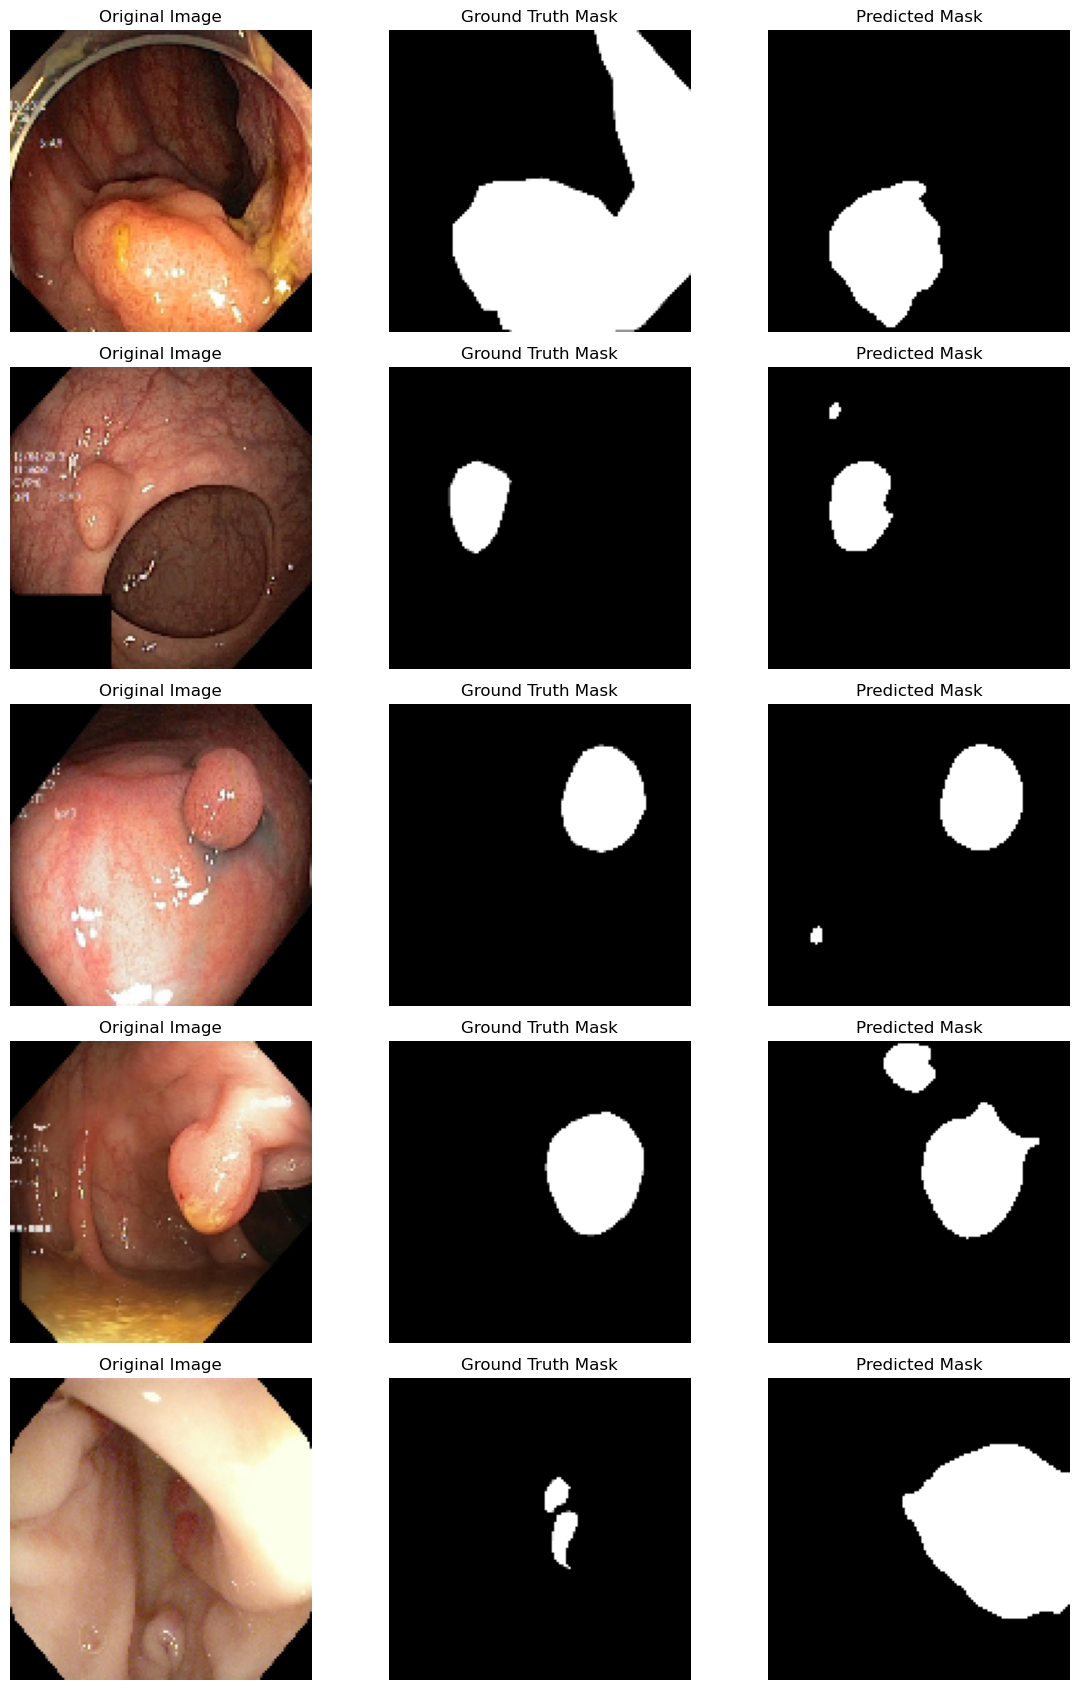

In [111]:
random_indices = random.sample(range(len(X_test)), 5)
preds_test = resnet.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Initialize subplots
plt.figure(figsize=(12, 17))

for i, random_index in enumerate(random_indices):
    # Plot the image, ground truth mask, and predicted mask side by side
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(X_test[random_index]) 
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(Y_test[random_index], cmap='gray') 
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(preds_test_t[random_index], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Evaluation

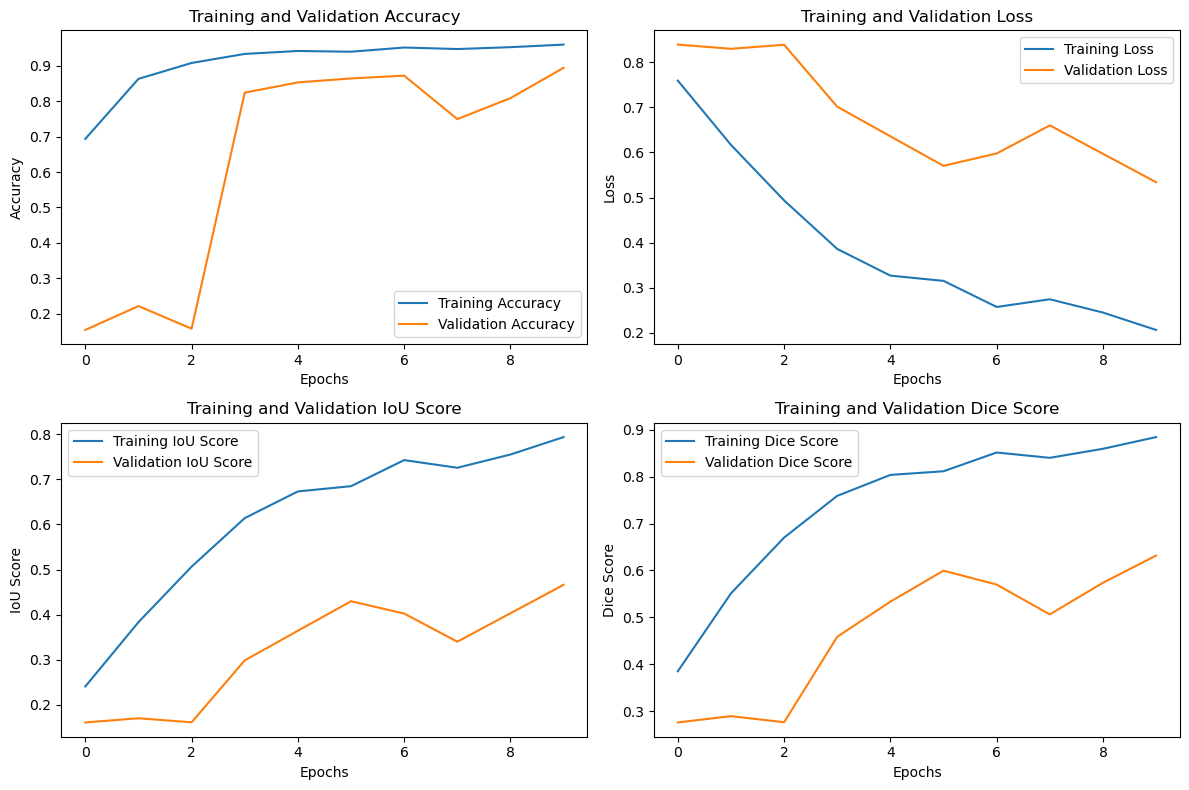

In [112]:
train_accuracy = history_resnet.history['accuracy']
train_loss = history_resnet.history['loss']
iou_score = history_resnet.history['iou_score']
f1_score = history_resnet.history['f1-score']

val_accuracy = history_resnet.history['val_accuracy']
val_loss = history_resnet.history['val_loss']
val_iou_score = history_resnet.history['val_iou_score']
val_f1_score = history_resnet.history['val_f1-score']

# Plot the learning curves
plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iou_score, label='Training IoU Score')
plt.plot(val_iou_score, label='Validation IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.title('Training and Validation IoU Score')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(f1_score, label='Training Dice Score')
plt.plot(val_f1_score, label='Validation Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()

plt.tight_layout()
plt.show()

In [113]:
# For the last 5 epochs
last_epochs = -5

# Calculate the mean values for the last 5 epochs from the training set
mean_train_iou_score_last5 = mean(iou_score[last_epochs:])
mean_train_dice_score_last5 = mean(f1_score[last_epochs:])

# Calculate the mean values for the last 5 epochs from the validation set
mean_val_iou_score_last5 = mean(val_iou_score[last_epochs:])
mean_val_dice_score_last5 = mean(val_f1_score[last_epochs:])

# Display the results for the last 5 epochs
print(f"Last 5 Epochs - Training Set - Mean IOU Score: {mean_train_iou_score_last5}")
print(f"Last 5 Epochs - Training Set - Mean Dice Score: {mean_train_dice_score_last5}")
print(f"Last 5 Epochs - Validation Set - Mean IOU Score: {mean_val_iou_score_last5}")
print(f"Last 5 Epochs - Validation Set - Mean Dice Score: {mean_val_dice_score_last5}")


Last 5 Epochs - Training Set - Mean IOU Score: 0.7405178546905518
Last 5 Epochs - Training Set - Mean Dice Score: 0.8497262835502625
Last 5 Epochs - Validation Set - Mean IOU Score: 0.4082254827022552
Last 5 Epochs - Validation Set - Mean Dice Score: 0.5763174772262574


Let's review the custom U-Net metrics:
Last 5 Epochs - Training Set - Mean IOU Score: 0.7383781433105469
Last 5 Epochs - Training Set - Mean Dice Score: 0.8491266965866089
Last 5 Epochs - Validation Set - Mean IOU Score: 0.437444269657135
Last 5 Epochs - Validation Set - Mean Dice Score: 0.6082937598228455

Despite being trained for just 10 epochs, compared to the 65 epochs of the previous model, this model exhibits higher performance across all metrics. Furthermore, a review of the learning curves suggests a rapid improvement trend, indicating that this model is likely to outperform the first one.

### EfficientNetb0 Backbone:

In [121]:
BACKBONE = 'efficientnetb0'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Create model
efficient = sm.Unet(BACKBONE, input_shape=(128, 128, 3), classes=1, encoder_weights = 'imagenet')
efficient.compile(optimizer='adam', loss=sm.losses.jaccard_loss, metrics=['accuracy', sm.metrics.iou_score, sm.metrics.FScore])
print(efficient.summary())

Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │     864 │ input_layer_10[0][0] │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stem_bn             │ (None, 64, 64,    │     128 │ stem_conv[0][0]      │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ stem_activation     │ (None, 64, 64,    │       0 │ stem_bn[0][0]        │
│ (Activation)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │     288 │ stem_activation[0][… │
│ (DepthwiseConv2D)   │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_bn          │ (None, 64, 64,    │     128 │ block1a_dwconv[0][0] │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_activation  │ (None, 64, 64,    │       0 │ block1a_bn[0][0]     │
│ (Activation)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │       0 │ block1a_activation[… │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │       0 │ block1a_se_squeeze[… │
│ (Reshape)           │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │     264 │ block1a_se_reshape[… │
│ (Conv2D)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │     288 │ block1a_se_reduce[0… │
│ (Conv2D)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │       0 │ block1a_activation[… │
│ (Multiply)          │ 32)               │         │ block1a_se_expand[0… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │     512 │ block1a_se_excite[0… │
│ (Conv2D)            │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │      64 │ block1a_project_con… │
│ (BatchNormalizatio… │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2a_expand_conv │ (None, 64, 64,    │   1,536 │ block1a_project_bn[… │
│ (Conv2D)            │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2a_expand_bn   │ (None, 64, 64,    │     384 │ block2a_expand_conv… │
│ (BatchNormalizatio… │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2a_expand_act… │ (None, 64, 64,    │       0 │ block2a_expand_bn[0

 Total params: 10,115,501 (38.59 MB)

 Trainable params: 10,071,501 (38.42 MB)

 Non-trainable params: 44,000 (171.88 KB)

None


In [122]:
history_efficient = efficient.fit(X_train, Y_train, validation_split = 0.2, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.5996 - f1-score: 0.3335 - iou_score: 0.2045 - loss: 0.7955 - val_accuracy: 0.1873 - val_f1-score: 0.2833 - val_iou_score: 0.1660 - val_loss: 0.8340
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.9076 - f1-score: 0.6148 - iou_score: 0.4464 - loss: 0.5536 - val_accuracy: 0.4915 - val_f1-score: 0.3705 - val_iou_score: 0.2289 - val_loss: 0.7711
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.9469 - f1-score: 0.7797 - iou_score: 0.6404 - loss: 0.3596 - val_accuracy: 0.7578 - val_f1-score: 0.4907 - val_iou_score: 0.3273 - val_loss: 0.6727
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.9575 - f1-score: 0.8462 - iou_score: 0.7341 - loss: 0.2659 - val_accuracy: 0.8374 - val_f1-score: 0.5674 - val_iou_score: 0.3978 - val_loss: 0.6022
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.9585 - f1-score: 0.8776 - iou_score: 0.7834 - loss: 0.2166 - val_accuracy: 0.8836 - val_

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 631ms/step


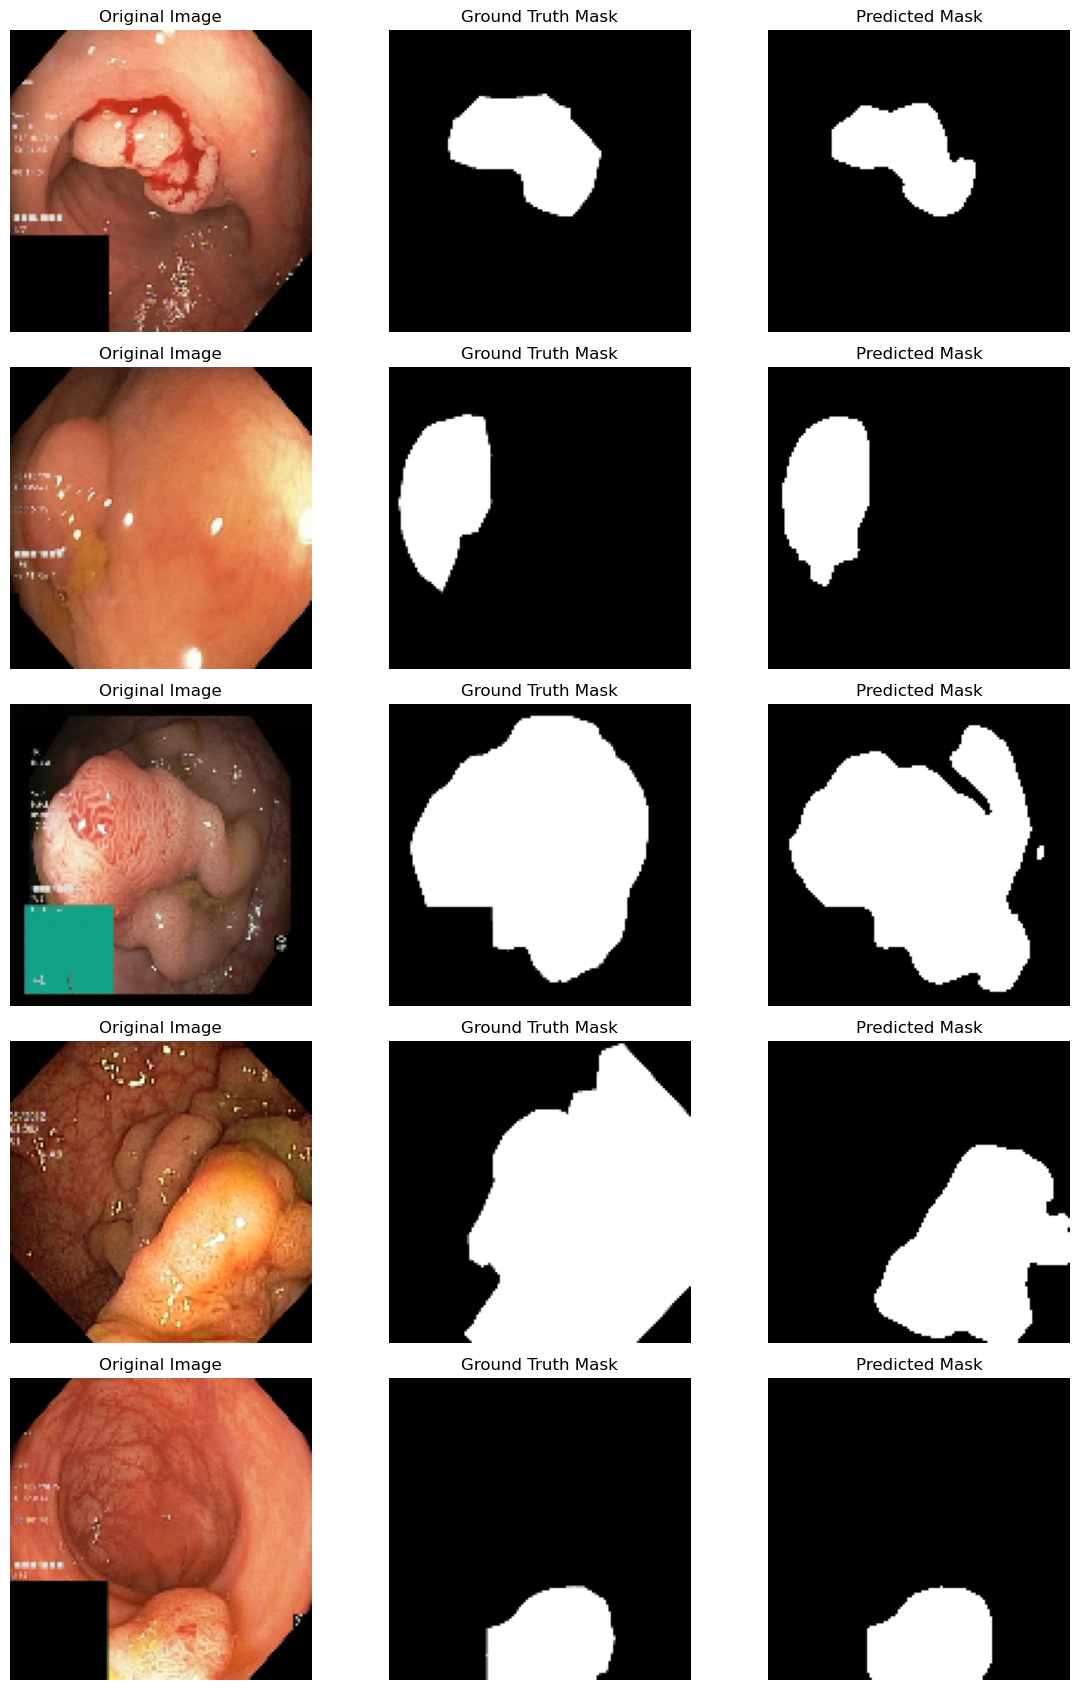

In [123]:
random_indices = random.sample(range(len(X_test)), 5)
preds_test = efficient.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Initialize subplots
plt.figure(figsize=(12, 17))

for i, random_index in enumerate(random_indices):
    # Plot the image, ground truth mask, and predicted mask side by side
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(X_test[random_index]) 
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(Y_test[random_index], cmap='gray') 
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(preds_test_t[random_index], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

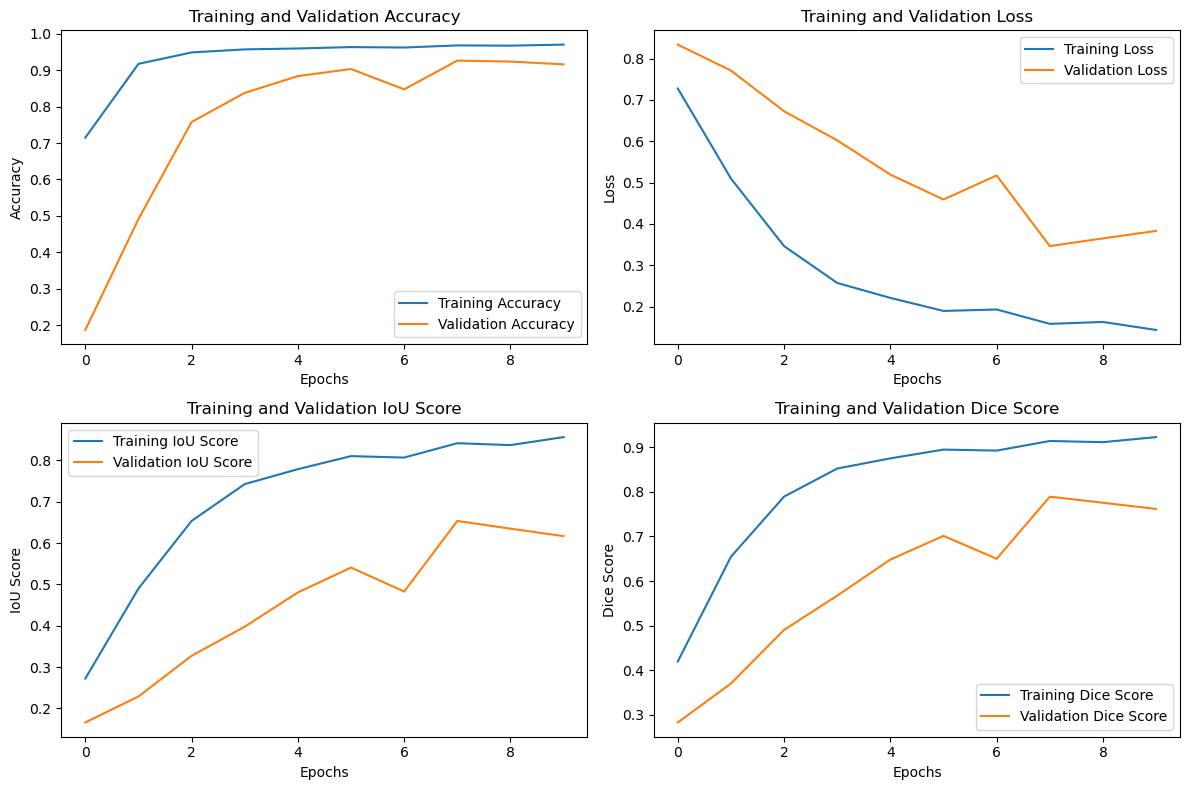

In [125]:
train_accuracy = history_efficient.history['accuracy']
train_loss = history_efficient.history['loss']
iou_score = history_efficient.history['iou_score']
f1_score = history_efficient.history['f1-score']

val_accuracy = history_efficient.history['val_accuracy']
val_loss = history_efficient.history['val_loss']
val_iou_score = history_efficient.history['val_iou_score']
val_f1_score = history_efficient.history['val_f1-score']

# Plot the learning curves
plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iou_score, label='Training IoU Score')
plt.plot(val_iou_score, label='Validation IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.title('Training and Validation IoU Score')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(f1_score, label='Training Dice Score')
plt.plot(val_f1_score, label='Validation Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()

plt.tight_layout()
plt.show()

In [126]:
# For the last 5 epochs
last_epochs = -5

# Calculate the mean values for the last 5 epochs from the training set
mean_train_iou_score_last5 = mean(iou_score[last_epochs:])
mean_train_dice_score_last5 = mean(f1_score[last_epochs:])

# Calculate the mean values for the last 5 epochs from the validation set
mean_val_iou_score_last5 = mean(val_iou_score[last_epochs:])
mean_val_dice_score_last5 = mean(val_f1_score[last_epochs:])

# Display the results for the last 5 epochs
print(f"Last 5 Epochs - Training Set - Mean IOU Score: {mean_train_iou_score_last5}")
print(f"Last 5 Epochs - Training Set - Mean Dice Score: {mean_train_dice_score_last5}")
print(f"Last 5 Epochs - Validation Set - Mean IOU Score: {mean_val_iou_score_last5}")
print(f"Last 5 Epochs - Validation Set - Mean Dice Score: {mean_val_dice_score_last5}")


Last 5 Epochs - Training Set - Mean IOU Score: 0.8306502938270569
Last 5 Epochs - Training Set - Mean Dice Score: 0.906827700138092
Last 5 Epochs - Validation Set - Mean IOU Score: 0.5858417987823487
Last 5 Epochs - Validation Set - Mean Dice Score: 0.7354464054107666


This model outperforms the other two, reaching a performance plateau after just 10 epochs. The Dice score consistently remains around 90% for the last 5 epochs, culminating in the final epoch with an F1-score of 0.9242 and an IOU score of 0.8596.